# Aim

Turbulence screen generator that explicitly uses a generated basis, for easy modifications.

In [1]:
# imports

import sys
sys.path.append("..")
from hcipy.hcipy import *
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import convolve2d
%matplotlib inline

In [2]:
# global parameter definitions

wavelength = 5e-7
dt = 1/1000
T = 0.1
D = 10.95
r0 = 16.5e-2   
k = 2 * np.pi / wavelength
p = 48
times = np.arange(0, T, dt)
pupil_grid = make_pupil_grid(p, diameter=D)
aperture = circular_aperture(D)(pupil_grid)

In [3]:
modes = [i for i in range(1, 3)] # 1 is tip 2 is tilt
basis = np.vstack([zernike(*ansi_to_zernike(i), D=D, grid=pupil_grid) for i in modes]).T

In [4]:
outer_scale   = 20 
wind_velocity = 15
Cn2           = r0**(-5. / 3) / (0.423 * k**2)

def turbulence_phases():
    # returns a list of Fields representing the turbulence phases over time
    single_layer_atmos = InfiniteAtmosphericLayer(pupil_grid,  Cn_squared=Cn2, L0=outer_scale, 
                                                  velocity=wind_velocity, use_interpolation=True)
    single_layer_turb = [None] * times.size
    for n in range(times.size):
        single_layer_atmos.evolve_until(times[n])
        turb = single_layer_atmos.phase_for(wavelength)
        single_layer_turb[n] = Field(turb, grid=pupil_grid) * aperture
    return single_layer_turb

In [5]:
phases = turbulence_phases()

In [6]:
# separate out TT
tt_phases = [None] * times.size
basis_t = basis.T
to_multiply = basis.dot(np.linalg.inv(basis_t.dot(basis)).dot(basis_t))
for i in range(times.size):
    tt_phases[i] = Field(to_multiply.dot(phases[i]), pupil_grid)

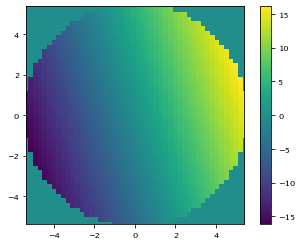

In [7]:
imshow_field(tt_phases[0])
plt.colorbar()

In [8]:
def center_of_mass(f):
    # takes in a Field, returns its CM.
    # rewriting because there seem to be weird bugs with the scipy inbuilt
    s = f.grid.shape[0]
    x, y = (n.flatten() for n in np.meshgrid(np.linspace(1, s+1, s), np.linspace(1, s+1, s)))
    return np.array((sum(f*x), sum(f*y)))/sum(f)

In [9]:
wf = Wavefront(aperture)
focal_grid = make_focal_grid_from_pupil_grid(pupil_grid, 8, 12)
#(8, 16) is in HCIPy documentation but that throws a warning for fov>1.33
propagator = FraunhoferPropagator(pupil_grid, focal_grid)
wf.electric_field *= np.exp(-1j * tt_phases[0] * k)
psf = propagator(wf)

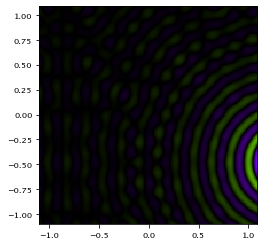

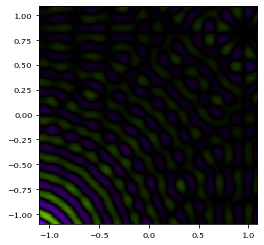

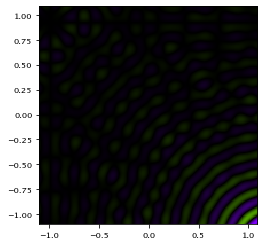

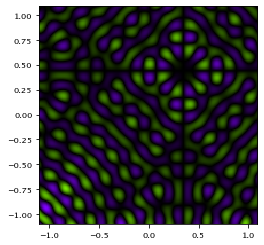

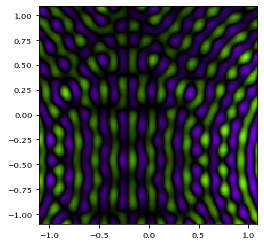

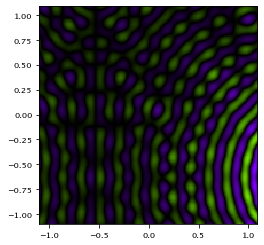

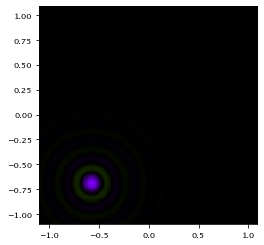

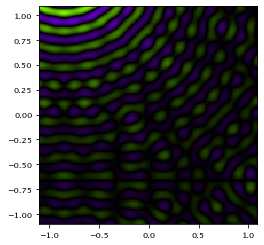

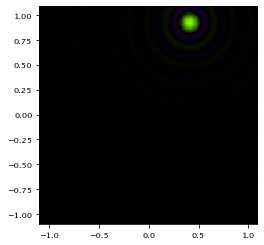

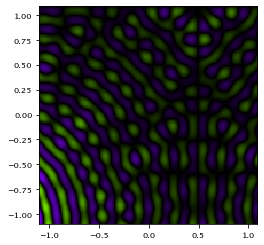

In [10]:
# now do all of this in a loop
conversion = 1
cm = np.zeros((times.size, 2))
for i in range(times.size):
    wf = Wavefront(aperture * np.exp(-1j * tt_phases[i] * k))
    efield = np.abs(propagator(wf).electric_field)**2
    if not i % 10:
        imshow_field(propagator(wf).electric_field)
        plt.show()
    cm[i] = center_of_mass(efield)
    # intensities are strictly positive and also the square of electric field
    
cm *= conversion    
cm -= np.tile(np.mean(cm, axis=0), (times.size, 1))
cm = cm.T

Text(0.5, 1.0, 'Turbulence tip-tilt deviations')

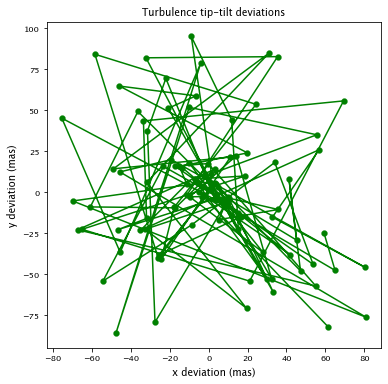

In [11]:
plt.figure(figsize=(6,6))
plt.plot(cm[0], cm[1], 'go-')
plt.xlabel("x deviation (mas)")
plt.ylabel("y deviation (mas)")
plt.title("Turbulence tip-tilt deviations")

(0.01, 369161.8706244233)

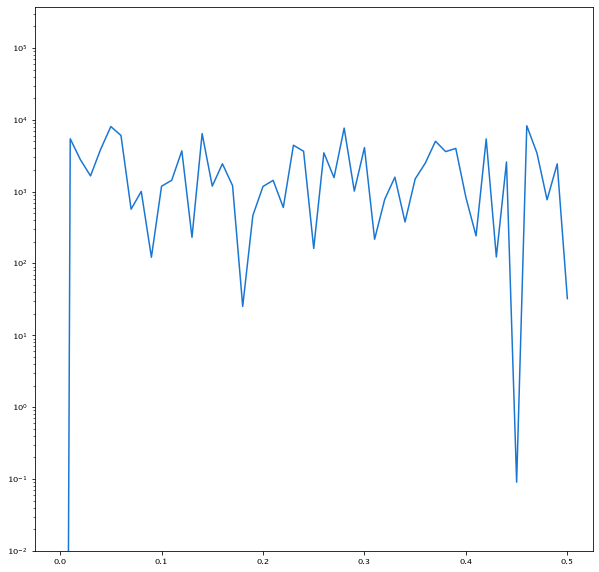

In [12]:
from scipy.signal import periodogram
plt.figure(figsize=(10,10))
plt.semilogy(*periodogram(cm[0]))
plt.ylim(1e-2)